In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend
from keras import metrics
from keras.datasets import cifar10

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

Using TensorFlow backend.


## Load the datasets

In [2]:
(xTrain, _), (xTest, yTest) = cifar10.load_data()
yTest = np.squeeze(yTest, axis=1)
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(50000, 3072)
(10000, 3072)


## Declare the parameters and layers

In [3]:
numEpochs = 100
sizeBatch = 32
dimInter1 = 256
dimInter2 = 64
dimInter3 = 16
dimEncode = 2
stdEps = 1.0 
ratRecon = 0.998
nameOptim = 'adam'

## Construct the encoder and decoder

In [4]:
layEncInt1 = Dense(dimInter1, activation='relu')
layEncInt2 = Dense(dimInter2, activation='relu')
layEncInt3 = Dense(dimInter3, activation='relu')
layMean = Dense(dimEncode)
laySigma = Dense(dimEncode)
layDecInt1 = Dense(dimInter3, activation='relu')
layDecInt2 = Dense(dimInter2, activation='relu')
layDecInt3 = Dense(dimInter1, activation='relu')
layDecode = Dense(dimInput, activation='sigmoid')

inputs = Input(shape=(dimInput,))
interEncode1 = layEncInt1(inputs)
interEncode2 = layEncInt2(interEncode1)
interEncode3 = layEncInt3(interEncode2)
zMean = layMean(interEncode3)
zSigmaLog = laySigma(interEncode3) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = backend.random_normal(shape=(backend.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + backend.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z)

inputZ = Input(shape=(dimEncode,))
interDecode1 = layDecInt1(inputZ)
interDecode2 = layDecInt2(interDecode1)
interDecode3 = layDecInt3(interDecode2)
decode = layDecode(interDecode3)
decoder = Model(inputZ, decode)

## Construct the autoencoder

In [5]:
vae = Model(inputs, decoder(encoder(inputs)))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 804244    
_________________________________________________________________
model_2 (Model)              (None, 3072)              807280    
Total params: 1,611,524
Trainable params: 1,611,524
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(tensorInput, tensorDecode)
        lossKL = - 0.5 * backend.sum(1 + 2 * zSigmaLog - backend.square(zMean) - backend.square(backend.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss


vae.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))
tic = time()
history = vae.fit(xTrain, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 14s 277us/step - loss: 0.6879 - val_loss: 0.6881
Epoch 2/100
50000/50000 [==============================] - 13s 261us/step - loss: 0.6878 - val_loss: 0.6880
Epoch 3/100
50000/50000 [==============================] - 13s 266us/step - loss: 0.6878 - val_loss: 0.6880
Epoch 4/100
50000/50000 [==============================] - 13s 268us/step - loss: 0.6878 - val_loss: 0.6880
Epoch 5/100
50000/50000 [==============================] - 13s 258us/step - loss: 0.6878 - val_loss: 0.6881
Epoch 6/100
50000/50000 [==============================] - 14s 281us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 7/100
50000/50000 [==============================] - 14s 278us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 8/100
50000/50000 [==============================] - 14s 279us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 9/100
50000/50000 [==============================] - 14s 283us/step - loss: 0.68

Epoch 76/100
50000/50000 [==============================] - 14s 285us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 77/100
50000/50000 [==============================] - 14s 285us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 78/100
50000/50000 [==============================] - 14s 281us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 79/100
50000/50000 [==============================] - 14s 283us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 80/100
50000/50000 [==============================] - 14s 277us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 81/100
50000/50000 [==============================] - 14s 282us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 82/100
50000/50000 [==============================] - 14s 278us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 83/100
50000/50000 [==============================] - 14s 282us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 84/100
50000/50000 [==============================] - 14s 278us/step - loss: 0.6877 - val_loss: 0.6880
Epoch 85/100
50000/

## Show the historical training progress 

traing consumed: 1389.4737844467163 seconds


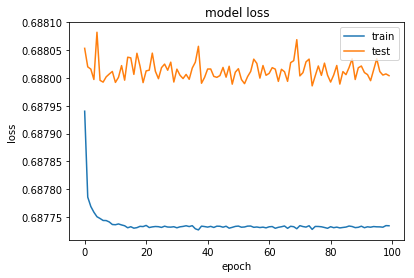

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

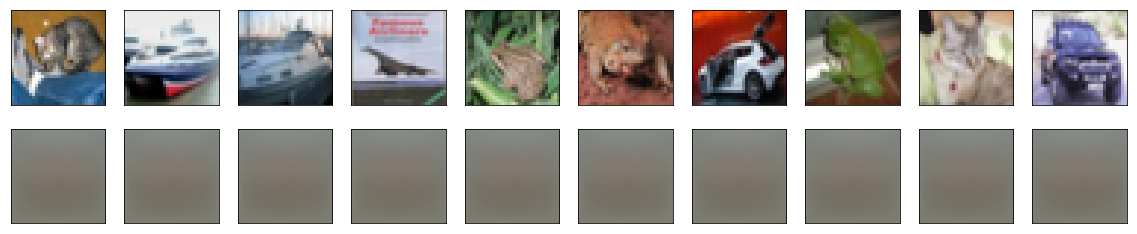

In [9]:
plotCompDecode(xTest, decodeTest, sizeDigit = (32, 32, 3))

## Plot the scatter of the encoding space

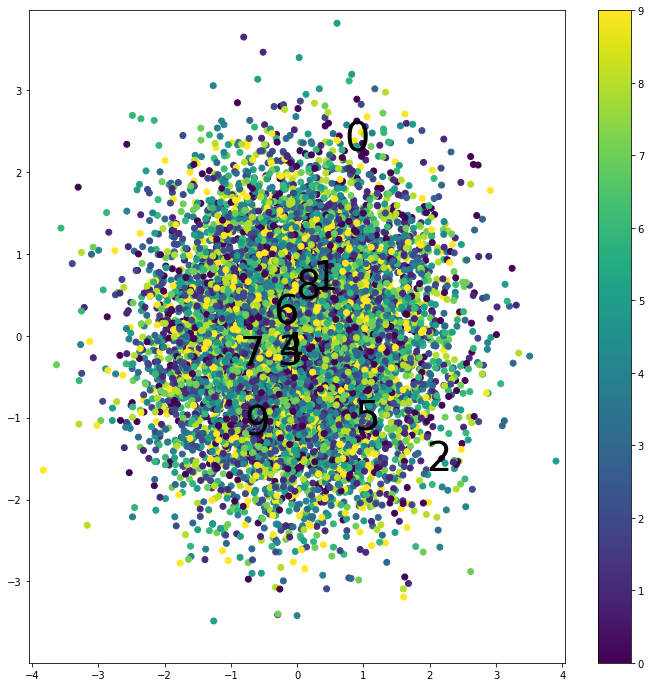

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

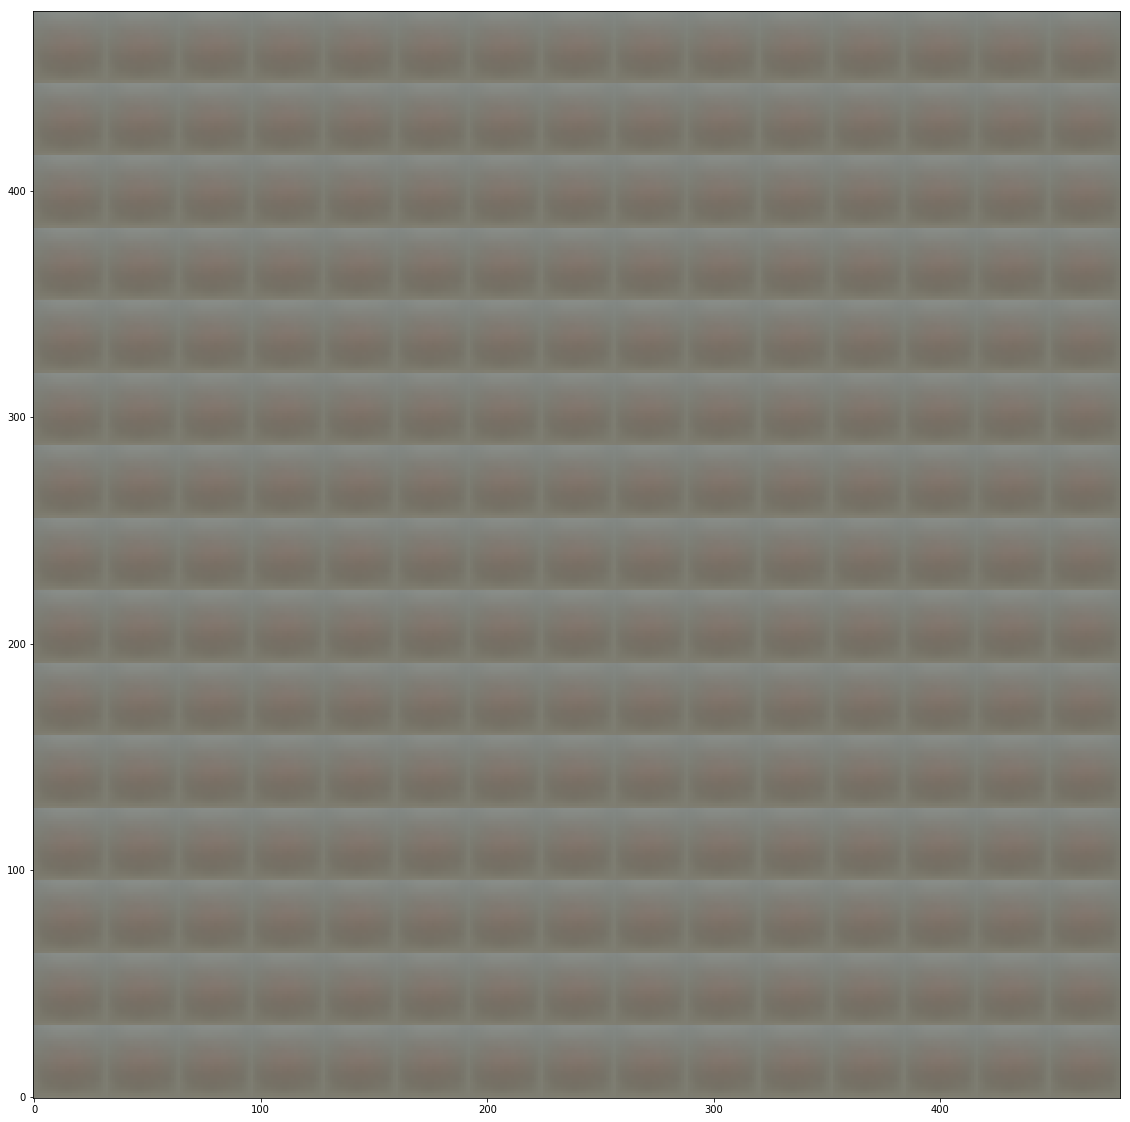

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (32,32,3), xlim, ylim)

In [12]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

1389.4737844467163 0.6877338347053528 0.688004183101654 -0.014677623
